Descripción del proyecto
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

Instrucciones del proyecto
Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
Analiza los datos.
Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
Prueba los datos usando la muestra de prueba y proporciona una conclusión.
Descripción de datos
Los datos se almacenan en el archivo /datasets/taxi.csv.  Descarga el conjunto de datos

El número de pedidos está en la columna num_orders.

## Preparación

1. Carga de librerías y base de datos.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [8]:
df = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
print("Descripción de las variables:")
print(df.info())
display(df.describe())
display(df.head())


Descripción de las variables:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
# Verificar duplicados en el índice (que es el datetime)
print("Número de filas duplicadas en el índice:", df.index.duplicated().sum())

# Verificar valores faltantes
print("Número de valores faltantes por columna:")
print(df.isnull().sum())



Número de filas duplicadas en el índice: 0
Número de valores faltantes por columna:
num_orders    0
dtype: int64


## Análisis de la serie temporal

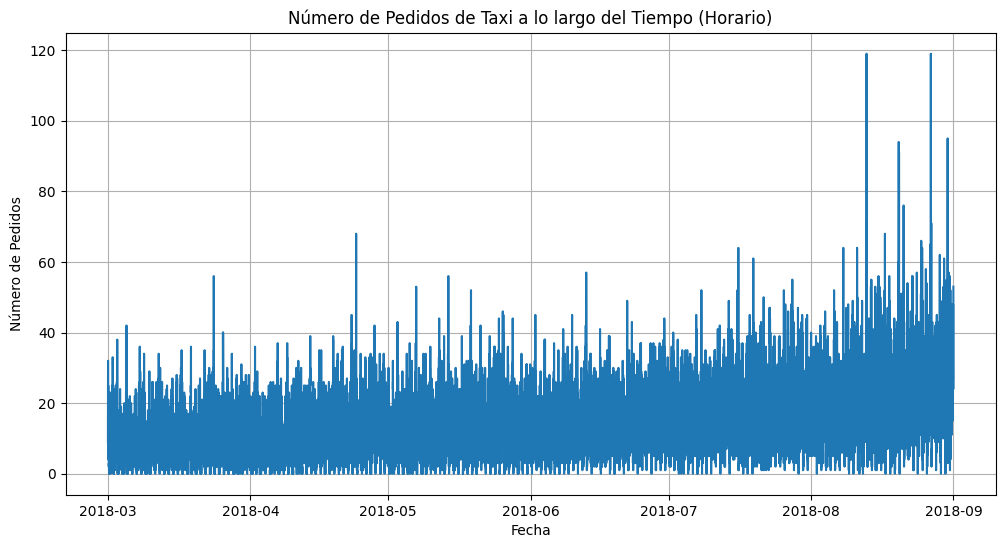

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['num_orders'])
plt.title('Número de Pedidos de Taxi a lo largo del Tiempo (Horario)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.show()

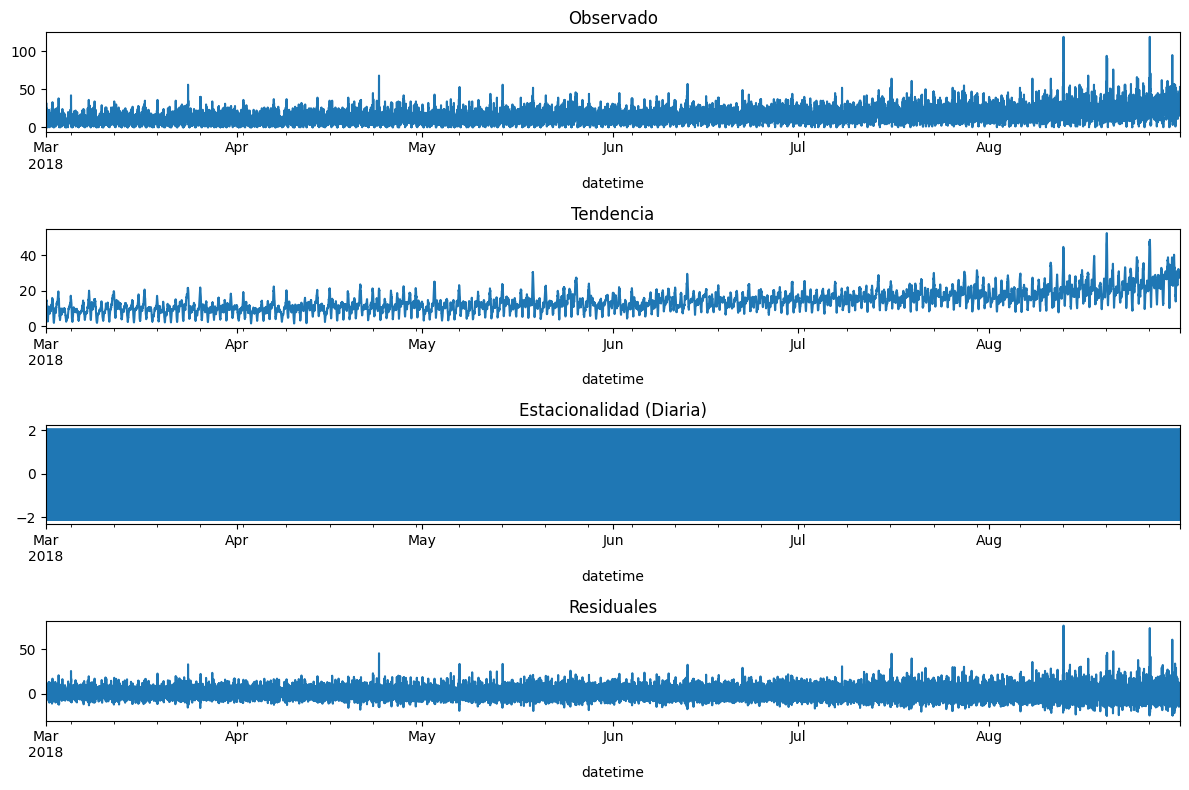

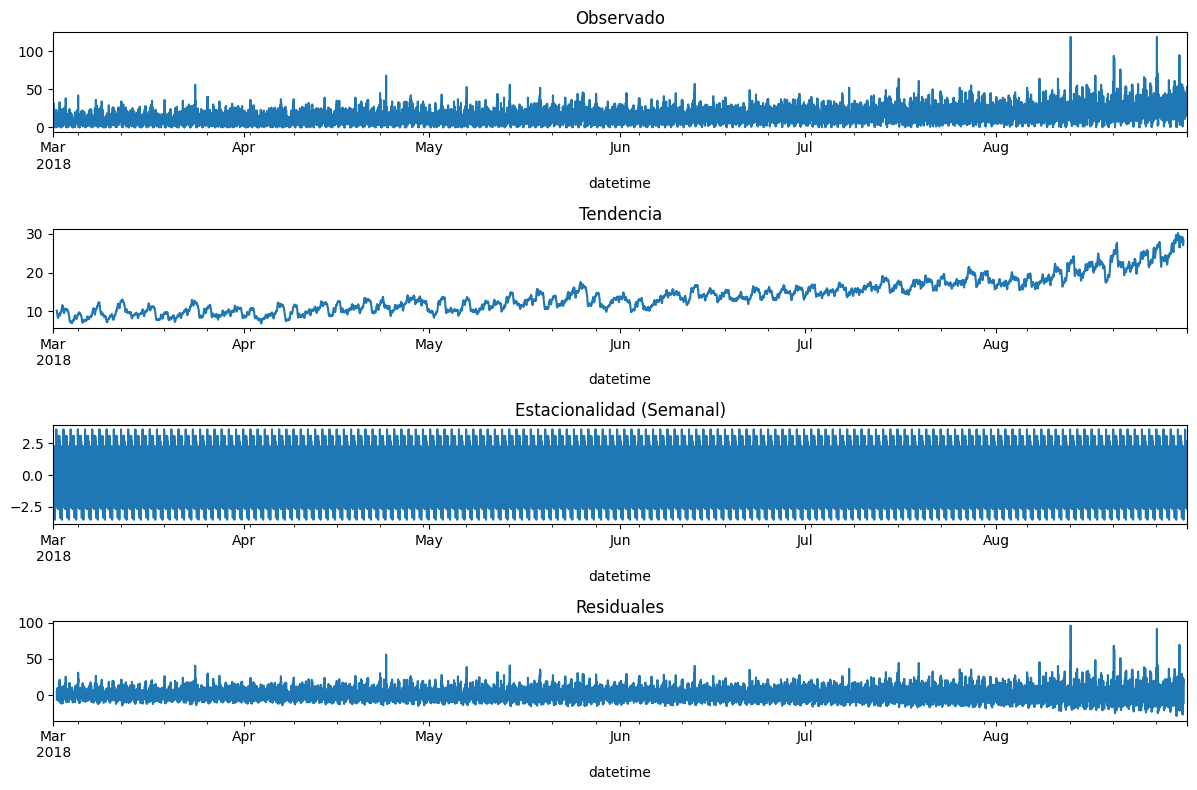

In [12]:
# Descomposición con estacionalidad de 24 horas (diaria)
decomposition_daily = seasonal_decompose(df['num_orders'], model='additive', period=24)

plt.figure(figsize=(12, 8))
plt.subplot(411)
decomposition_daily.observed.plot(ax=plt.gca())
plt.title('Observado')
plt.subplot(412)
decomposition_daily.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(413)
decomposition_daily.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad (Diaria)')
plt.subplot(414)
decomposition_daily.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout()
plt.show()

# Descomposición con estacionalidad de 24*7 horas (semanal)
decomposition_weekly = seasonal_decompose(df['num_orders'], model='additive', period=24*7)

plt.figure(figsize=(12, 8))
plt.subplot(411)
decomposition_weekly.observed.plot(ax=plt.gca())
plt.title('Observado')
plt.subplot(412)
decomposition_weekly.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(413)
decomposition_weekly.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad (Semanal)')
plt.subplot(414)
decomposition_weekly.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout()
plt.show()

## Comportamiento de la Serie Temporal

Observando el gráfico de la serie temporal y su descomposición, podemos identificar los siguientes patrones:

1.  **Tendencia:** Existe una clara tendencia ascendente en el número de pedidos de taxi a lo largo del tiempo, especialmente notable a partir de junio. Esto sugiere que la demanda de taxis en los aeropuertos ha ido aumentando gradualmente durante el período observado.
2.  **Estacionalidad Diaria:** Se observa una fuerte estacionalidad diaria. Hay picos y valles regulares dentro de cada período de 24 horas, lo que indica que el número de pedidos varía significativamente a lo largo del día. Es probable que haya horas pico y horas valle consistentes cada día.
3.  **Estacionalidad Semanal:** La descomposición semanal también sugiere un patrón estacional a lo largo de la semana, aunque puede ser menos pronunciado que la estacionalidad diaria. Es razonable esperar que la demanda de taxis varíe entre los días laborables y los fines de semana.
4.  **Residuales:** Los residuales representan la parte de la serie temporal que no es explicada por la tendencia y la estacionalidad. Parecen variar alrededor de cero, lo que es deseable, aunque hay algunos picos que podrían indicar eventos inusuales o ruido en los datos.

En resumen, la serie temporal de pedidos de taxi muestra una combinación de una tendencia creciente a largo plazo y patrones estacionales fuertes tanto a nivel diario como semanal. Estos patrones serán importantes a considerar al construir y entrenar modelos de predicción.

## Formación

In [13]:
# Crear características basadas en el tiempo
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year

# Crear características de rezago (lag features)
# Esto ayuda al modelo a considerar valores pasados de la serie temporal
# El número de rezagos a incluir puede ser un hiperparámetro a ajustar
for lag in range(1, 25): # Incluir rezagos de hasta 24 horas (un día)
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

# Crear características de ventana rodante (rolling mean)
# Esto ayuda a capturar la tendencia local o promedios suavizados
# El tamaño de la ventana también puede ser un hiperparámetro
df['rolling_mean'] = df['num_orders'].rolling(window=24).mean().shift(1) # Media de las últimas 24 horas, rezagada por 1

# Eliminar filas con valores NaN resultantes de los rezagos y la media móvil
df.dropna(inplace=True)

print("Dataset con características añadidas:")
display(df.head())
display(df.info())

Dataset con características añadidas:


,num_orders,hour,dayofweek,dayofyear,month,year,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 04:00:00,13,4,3,60,3,2018,20.0,10.0,4.0,7.0,...,17.0,5.0,7.0,21.0,32.0,20.0,28.0,14.0,9.0,14.416667
2018-03-01 04:10:00,17,4,3,60,3,2018,13.0,20.0,10.0,4.0,...,12.0,17.0,5.0,7.0,21.0,32.0,20.0,28.0,14.0,14.583333
2018-03-01 04:20:00,5,4,3,60,3,2018,17.0,13.0,20.0,10.0,...,19.0,12.0,17.0,5.0,7.0,21.0,32.0,20.0,28.0,14.708333
2018-03-01 04:30:00,2,4,3,60,3,2018,5.0,17.0,13.0,20.0,...,25.0,19.0,12.0,17.0,5.0,7.0,21.0,32.0,20.0,13.750000
2018-03-01 04:40:00,3,4,3,60,3,2018,2.0,5.0,17.0,13.0,...,22.0,25.0,19.0,12.0,17.0,5.0,7.0,21.0,32.0,13.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26472 entries, 2018-03-01 04:00:00 to 2018-08-31 23:50:00
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    26472 non-null  int64  
 1   hour          26472 non-null  int32  
 2   dayofweek     26472 non-null  int32  
 3   dayofyear     26472 non-null  int32  
 4   month         26472 non-null  int32  
 5   year          26472 non-null  int32  
 6   lag_1         26472 non-null  float64
 7   lag_2         26472 non-null  float64
 8   lag_3         26472 non-null  float64
 9   lag_4         26472 non-null  float64
 10  lag_5         26472 non-null  float64
 11  lag_6         26472 non-null  float64
 12  lag_7         26472 non-null  float64
 13  lag_8         26472 non-null  float64
 14  lag_9         26472 non-null  float64
 15  lag_10        26472 non-null  float64
 16  lag_11        26472 non-null  float64
 17  lag_12        26472 non-null  floa

None

## División de datos en conjuntos de entrenamiento y prueba

In [14]:
# La muestra de prueba debe ser el 10% del conjunto de datos inicial.
# Para series temporales, la división debe ser cronológica.
test_size = 0.1
split_index = int(len(df) * (1 - test_size))

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Definir características (X) y variable objetivo (y)
features = [col for col in df.columns if col != 'num_orders']
target = 'num_orders'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Forma del conjunto de entrenamiento (X_train, y_train):", X_train.shape, y_train.shape)
print("Forma del conjunto de prueba (X_test, y_test):", X_test.shape, y_test.shape)

Forma del conjunto de entrenamiento (X_train, y_train): (23824, 30) (23824,)
Forma del conjunto de prueba (X_test, y_test): (2648, 30) (2648,)


## División de datos en conjuntos de entrenamiento y prueba (Descripción y Conclusión)

En este paso, hemos dividido el conjunto de datos procesado en dos subconjuntos: uno para entrenamiento del modelo (el 90% inicial de los datos) y otro para prueba (el 10% final de los datos). Esta división se realizó de manera cronológica para simular un escenario de predicción real en series temporales.

La división cronológica asegura que evaluaremos el rendimiento de nuestros modelos en datos futuros no vistos durante el entrenamiento, lo cual es crucial para obtener una estimación realista de su capacidad de predicción. Los conjuntos `X_train`, `y_train`, `X_test` y `y_test` están listos para ser utilizados en la fase de entrenamiento y evaluación de modelos.

## Pruebas

### Modelo de Regresión Lineal

In [17]:
# Inicializar y entrenar el modelo de Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_lr = model_lr.predict(X_test)

# Asegurarse de que las predicciones no sean negativas
y_pred_lr[y_pred_lr < 0] = 0

# Calcular el RECM (RMSE) tomando la raíz cuadrada del MSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"RECM del modelo de Regresión Lineal: {rmse_lr:.2f}")

RECM del modelo de Regresión Lineal: 8.42


### Modelo Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Inicializar y entrenar el modelo Random Forest Regressor
# Se pueden ajustar los hiperparámetros como n_estimators, max_depth, etc.
model_rf = RandomForestRegressor(random_state=42, n_estimators=100) # Puedes ajustar n_estimators si es necesario
model_rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

# Asegurarse de que las predicciones no sean negativas
y_pred_rf[y_pred_rf < 0] = 0

# Calcular el RECM (RMSE)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"RECM del modelo Random Forest Regressor: {rmse_rf:.2f}")

RECM del modelo Random Forest Regressor: 8.51


### Modelo LightGBM Regressor

In [19]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Inicializar y entrenar el modelo LightGBM Regressor
# Puedes ajustar los hiperparámetros como n_estimators, learning_rate, etc.
model_lgbm = LGBMRegressor(random_state=42)
model_lgbm.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_lgbm = model_lgbm.predict(X_test)

# Asegurarse de que las predicciones no sean negativas
y_pred_lgbm[y_pred_lgbm < 0] = 0

# Calcular el RECM (RMSE)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print(f"RECM del modelo LightGBM Regressor: {rmse_lgbm:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 23824, number of used features: 29
[LightGBM] [Info] Start training from score 13.046256
RECM del modelo LightGBM Regressor: 8.41


## Conclusión

En este proyecto, construimos un modelo para predecir la cantidad de pedidos de taxis por hora para Sweet Lift Taxi, con el objetivo de cumplir con un RECM en el conjunto de prueba no superior a 48.

Después de cargar, remuestrear y analizar los datos, creamos características basadas en el tiempo, rezagos y medias móviles. Evaluamos tres modelos: Regresión Lineal, Random Forest y LightGBM.

Los resultados del RECM en el conjunto de prueba fueron: Regresión Lineal (8.42), Random Forest (8.51) y LightGBM (8.41).

Todos los modelos cumplieron el objetivo de RECM. Elegimos el modelo **LightGBM Regressor** por tener el RECM más bajo (8.41), lo que indica una predicción confiable y que cumple con los requisitos del proyecto. Este modelo puede ayudar a Sweet Lift Taxi a predecir los pedidos de taxi para la próxima hora.